In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from PIL import Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
train_folders = ['/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Train5.5/pos',
                 '/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Train5.5/neg']

In [3]:
test_folders = ['/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Test5.5/pos', 
                '/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Test5.5/neg']

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

image_width = 24
image_height = 40

pixel_depth = 255.0  # Number of levels per pixel.

def load_class(folder, min_num_images, im_height, im_width):

    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), im_height, im_width), dtype=np.float32)
  
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            #Image.open('image.png').convert('LA')
            image_data = (rgb2gray(ndimage.imread(image_file)).astype(float) - pixel_depth / 2) / pixel_depth
            #image_data = ((Image.open(image_file).convert('LA')).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (im_height, im_width):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, im_height, im_width, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_class(folder, min_num_images_per_class, im_height, im_width)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 90, image_height, image_width)
test_datasets = maybe_pickle(test_folders, 90, image_height, image_width)


/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Train5.5/pos.pickle already present - Skipping pickling.
/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Train5.5/neg.pickle already present - Skipping pickling.
/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Test5.5/pos.pickle already present - Skipping pickling.
/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/Test5.5/neg.pickle already present - Skipping pickling.


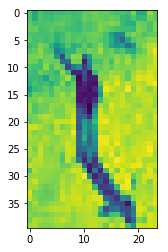

In [5]:
a = pickle.load(open(train_datasets[0]))
plt.imshow(a[0])


In [6]:
def make_arrays(nb_rows, img_h, img_w):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_h, img_w), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
  #print (num_classes)
    valid_dataset, valid_labels = make_arrays(valid_size, image_height, image_width)
    train_dataset, train_labels = make_arrays(train_size, image_height, image_width)
    vsize_per_class = valid_size // num_classes # 49
    tsize_per_class = train_size // num_classes # 250
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class #299
    #print (vsize_per_class)
    #print (tsize_per_class)
    #print (end_l)
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                #print (label)
        
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    #print (vsize_per_class)
                    #print (end_l)
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                #print (vsize_per_class)
                #print (end_l)
                
                #print (len(valid_dataset))
                #print (len(train_letter))
                #print (len(train_dataset))

                train_dataset[start_t:end_t, :, :] = train_letter
                #print (start_t)
                #print (end_t)
                train_labels[start_t:end_t] = label
                #print (train_labels)
                #print (valid_labels)
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    #print (train_labels)
    #print (valid_labels)
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 500
valid_size = 98
test_size = 216

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (500, 40, 24) (500,)
Validation: (98, 40, 24) (98,)
Testing: (216, 40, 24) (216,)


In [7]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [8]:
pickle_file = os.path.join('/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/', 'complete_dataset.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    print (pickle_file)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/complete_dataset.pickle


In [9]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 3129449


In [10]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [11]:
pickle_file = '/media/sumit/New Volume1/Project/From Henry/downsampled_image_by4/complete_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (500, 40, 24) (500,)
Validation set (98, 40, 24) (98,)
Test set (216, 40, 24) (216,)


In [12]:
from sklearn import datasets, neighbors, linear_model

train_dataset_temp = train_dataset
nsamples, nx, ny = train_dataset_temp.shape
X_train = train_dataset_temp.reshape((nsamples,nx*ny))

test_dataset_temp = test_dataset
nsamples, nx, ny = test_dataset_temp.shape
X_test = test_dataset_temp.reshape((nsamples,nx*ny))

y_train = train_labels
y_test = test_labels

logistic = linear_model.LogisticRegression()

print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression score: 0.842593


In [13]:
image_width = 24
image_height = 40
num_labels = 2

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_height * image_width)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (500, 960) (500, 2)
Validation set (98, 960) (98, 2)
Test set (216, 960) (216, 2)


In [42]:
graph = tf.Graph()
with graph.as_default():

    HIDDEN_UNITS = 100
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.

    tf_train_dataset = tf.constant(train_dataset)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    weights_1 = tf.Variable(
        tf.truncated_normal([image_height * image_width, HIDDEN_UNITS]))
    biases_1 = tf.Variable(tf.zeros([HIDDEN_UNITS]))
    
    layer_1_outputs = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    
    weights_2 = tf.Variable(
        tf.truncated_normal([HIDDEN_UNITS, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    logits = tf.nn.sigmoid(tf.matmul(layer_1_outputs, weights_2) + biases_2)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
    test_prediction = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [55]:
num_steps = 1401

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
                predictions, train_labels))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 0.693794
Training accuracy: 65.6%
Validation accuracy: 68.4%
Loss at step 100: 0.442518
Training accuracy: 87.2%
Validation accuracy: 83.7%
Loss at step 200: 0.418450
Training accuracy: 88.8%
Validation accuracy: 84.7%
Loss at step 300: 0.409484
Training accuracy: 89.4%
Validation accuracy: 84.7%
Loss at step 400: 0.406789
Training accuracy: 89.8%
Validation accuracy: 84.7%
Loss at step 500: 0.401739
Training accuracy: 90.4%
Validation accuracy: 84.7%
Loss at step 600: 0.399564
Training accuracy: 90.4%
Validation accuracy: 85.7%
Loss at step 700: 0.397750
Training accuracy: 90.8%
Validation accuracy: 85.7%
Loss at step 800: 0.396201
Training accuracy: 91.0%
Validation accuracy: 85.7%
Loss at step 900: 0.395838
Training accuracy: 91.2%
Validation accuracy: 85.7%
Loss at step 1000: 0.394114
Training accuracy: 91.2%
Validation accuracy: 86.7%
Loss at step 1100: 0.388311
Training accuracy: 91.6%
Validation accuracy: 85.7%
Loss at step 1200: 0.386497
Training acc

In [16]:
train_labels[0]

array([ 0.,  1.], dtype=float32)

In [17]:
test_labels[0]

array([ 1.,  0.], dtype=float32)

In [18]:
test_labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,